# GSMM comparison

In [2]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using Revise
using FFTW
using Compat
using WAV
using DSP
using Base64
using ForneyLab
using LinearAlgebra
using ProgressMeter
using PyPlot
using GaussianMixtures
using Random
using Printf
using BenchmarkTools
;

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


┌ Info: Precompiling DSP [717857b8-e6f2-59f4-9121-6e50c889abd2]
└ @ Base loading.jl:1273
┌ Info: Precompiling GaussianMixtures [cc18c42c-b769-54ff-9e2a-b28141a64aae]
└ @ Base loading.jl:1273


In [3]:
include("../extensions/ComplexNormal.jl")
include("../extensions/ComplexHGF.jl")
include("../extensions/ComplexToReal.jl")

include("../functions/auxiliary/workflow.jl") 
include("../functions/auxiliary/fourier.jl") 
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/visualization.jl")
include("../functions/preprocessing.jl") 

include("GSMM.jl")
;

## Parameters

In [5]:
# data generation parameters
sound_file = "../data/woman.wav"      # specify sound location
fs = 8000                             # specify desired sampling frequency
normalization_method = "max"          # specify normalization method
nr_freqs = 4                         # number of frequencies (excluding DC and fs/2)
nr_clusters = 3                       # number of clusters (needs to be larger than 2 (ForneyLab issue))
bufsize = 2*(nr_freqs+1)              # number of samples in the buffer

duration_train = 1                    # duration of training data in seconds
duration_test = 5                     # duration of testing data in seconds
stepsize_train = Int(bufsize)         # stepsize of training
stepsize_test = bufsize               # stepsize of testing

Σ_meas = 1e-10*Ic(bufsize)            # covariance matrix of measurement noise (over time in this case)
Σ_noise = 1e-2
;

## Load and process signals

In [6]:
# calculate number of samples
nr_samples_train = Int((fs*duration_train-bufsize)/stepsize_train) + 1
nr_samples_test = Int((fs*duration_test-bufsize)/stepsize_test) + 1

# load speech data
x_speech, fs_speech = wavread(sound_file, format="native")
fs_speech = Int(fs_speech)
x_speech = convert(Array{Float64,1}, squeeze(x_speech[:,1]))[1*fs_speech:(1+maximum([duration_train, duration_test]))*fs_speech-1]

# pre-process signals
y_speech = preprocess(x_speech, fs_speech)[1:fs*duration_train] 
y_speech_true = preprocess(x_speech, fs_speech)[1:fs*duration_test] 
y_speech_n = y_speech_true + sqrt(Σ_noise)*randn(size(y_speech_true))

# warp signal and take fft
f_speech = FFTovertime(y_speech, bufsize, bufsize-stepsize_train, rectangularwindow)
f_speech_n = FFTovertime(y_speech_n, bufsize, bufsize-stepsize_test, rectangularwindow)

# reduce fft 
fab_speech =  hcat(real.(f_speech[:,1]), 2*real.(f_speech[:,2:nr_freqs+1]), real.(f_speech[:,nr_freqs+2]), -real.(f_speech[:,1]), -2*imag.(f_speech[:,2:nr_freqs+1]), imag.(f_speech[:,nr_freqs+2]))
fab_speech_n =  hcat(real.(f_speech_n[:,1]), 2*real.(f_speech_n[:,2:nr_freqs+1]), real.(f_speech_n[:,nr_freqs+2]), -real.(f_speech_n[:,1]), -2*imag.(f_speech_n[:,2:nr_freqs+1]), imag.(f_speech_n[:,nr_freqs+2]))

# determine corresponding fft frequencies 
fi = abs.(FFTW.fftfreq(bufsize)[1:nr_freqs+2]*fs)[2:end-1]

# get the log abs values
z_speech = log.(abs2.(fab_speech[:,1:nr_freqs+2]) + abs2.(fab_speech[:,nr_freqs+3:end]))
z_speech_n = log.(abs2.(fab_speech_n[:,1:nr_freqs+2]) + abs2.(fab_speech_n[:,nr_freqs+3:end]))

# create time axis
t = collect(0:maximum([length(y_speech), length(y_speech_true)])-1)/fs

# create audioplayers for signals
audioplayers(y_speech, y_speech_n, fs=fs)
;

<source src="data:audio/wav;base64,UklGRjx9AABXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB9AAAtgQm+mdpevuqHLb784A2+HAnVvfu9cL3OJj49I9ADPs5eWj5KxJc+b2m6PnjRtz5OIrI+jaGVPp3i6T2k2te8S9wXvbB9nb1UzXO+EyCQvjqJLb4oopS9N8eRvUyiC71LCBY90cGjPUIFNT0z4p4767phvfVWq70zK9e9VI0RvpMRSb6uSka+aHEQvjsiz71hGqy9yX6PvIH/3z1kO10+n0yLPjLPqT5v/r0+zZ+8PlgHoT4LbRQ+hkHou0MDJL3JGJG9/49vvhclnL5cTFm+/jiuvVDdpb3/1469AfguPPZ6sz2ayI893XgaPVQembvC9Ta9uxvAvfFJ+r2y3zG+awZNvuuwL74wvAG+OV++vfL2Kby0iwU+HD18PiglmT558LY+i9fOPmthwj4EkVc+/XkePUXYDjxnAxK9FPdVvjsvr77PeYW+UPIPviDJA77M9g2+mQ8Tvchaxj0on/M9njhlPezLgzzwNAU9eIOePHi0pr31KzK+Xa87vh3RHL5yCRm+eicSvsYNl73W34c9ZXBCPuzthD6waJg+GmO9Pv59yD7L5pM+1yWxPekDZzltrqo7lezavbgMnr5JxKa+ootJvrVvF767Fi++AxvovQ2Z1zttj5E9AX6MPZ3qFD1CnwU8OAhpPMLiRzzpCKO9IkEhvosA772otjK97PFBvU9VT7thVyg+LkWgPhjMqj4M6K8+v4iYPhAmGz7iFZ49GtZJPebE7r3lXpm+gTKHvnGrN75pGFO+vXxhvlTExr0iUxc9N+GtPaKl4D1Vd+09qL+VPRP7gD2Sl3I9clsYvctKOL7vmT2+qCH/vWx/K77QMGG+2e4Avp6RRDxzBG097m+xPdjUMD5SEHk+YkJ6PvCUSj7KNyg+OTryPch0ij0viwq8W4dhvWW1bL21/Km9hIQdvo2bG77Qab+9zLezva9H3r09tXO9HDk3POdZN7puRSm9Ew87vTHa3rw61be8Dp6pvJVML7ukvVE9sTwRPugKZD6p7Ik+4e6hPmr0sz45ClM+2cYyPKtg0jtSYao8m6M/vl8DtL7Lp2e+MjbSvTKfO77JU1O+/GPFvEKh/T0E/fQ9CDDSPa8vIz4QvD0+Vc0aPk8Phj1FE5q8iE6ivUF1v73E7gG+VPw+vubNPr73GN29TE9rvVdbf72lbAG9gk4SPduKkT1Bmzk9/U0PPdBjGz1IWO48PmiXvKZ3UL1tjzO9z2bkvCwaDL1gJCG9wgoIveOQcbwn4ck7xNEBPEjBQ7s52QK7oJpkPKJ9bDt7R7i8MAgRvd4KX7wN7Va89XmhvJqDOjunAPY87eIKPWcGGj3ITFc9x2R8PfYaez1b+y09gB3yPMbZpTzcrXI8/QSBvDjtM71pbz+9/KNCvYfJi72m+Zi9G5FjvTRSS708GVK9nWAnvei8sLxjF6O8H6BRvDZmGzoqGUs8mgaePMm/Nj2HxoE9l9aCPY3vmj1m6809IQPHPWUWoj2JQGg9atspPboFiDzGALq8giCDvZmz0b3OGvC961HxvXwMAL5xzQy+G0PfvYx3mb2SDnK980MwvXcLSrwWDB48sg/hPGYSMD2Sq1U9lvqVPTv87j0vJhY+lgIuPrCPPz4CATM+vnzuPXuJmz393ig95tduvSJwD76sMR++iLwivnePWr7r52K+kFgivi8C572K/t69U5KYvQOky7s8AuU8T8gaPS84eT1cPME94CPiPQVz+T1xbh8+D/1JPt19aj7OsVo+WCLYPS3B0TwBZEk9/raVPDjeC75TP0a+SPC5vfObwb2jBEa+Uz8dvnkcnbyE6x68m0c4vW8iAT0nqds9Tc2kPSlGPj0eKJQ9lLeCPS0Un7uMcSS9U+IBvdOWZ71bz8C9VEy+vS5Ppr2UQ5m9PA+AvQ3aJ70npZO8Vrc/vKTda7x+/sG7LQAhPEqhbTyGwu+78YOOu/MqJDx/2io6y+V3vM/5zTou03M7Uu9vvMcFkrzdGSu8ogMbvMAe/rsRig66qfnWOyse2TtSHjI8ApYXPAiswDyMnh89pSH5PB+DijxgdME8etgHPYgKojxx1ok8RwjNPKjViTxrAJg6WN/TOXrhRruMUhC8kDoKvL74F7wPvOy7hosfvF2Lg7t31266dN/XukQuxzsFmtE7tWblOztRojzxhpk8JcAXPHJ3vTzNYOI8Ty0rPKii8ztNz8o8Av3FPLRvJTzjMwk8osdEO7JHmjrGT408+A+xO6umerwo2NA6/imHPJh6Wro+dbu7gir5O7oBpDqTK6w7OOgdPFy1IDuCgRY7zgZPPMY5czyrVBA7UtgJPARuQjyykzI8s9+3PIgixro4LIo8ixTpPHTPyDvdnKI8lqyUPMjzj7t0HWA8E1m7PAcZsbsb54e8BZMUO7wiEbxr5Tu8kDqHO3D89bt19x6714AnPPv1zrzcSC+8dVcIPd0JHDzTUBe9PLGbvAKMFj0H/Mo7bt0wvSL5dzxpC6s8ANo6vS3cGDxRqgk916EuvcLTFL0ZQOU84CgavDplOb3ISb68cOBTOkyMzLxT11a8/kR6vCOz5LyWFO07H1dXPLoyPL3J25O80wfmPJYTlbykCvu8BVxUO0CvS7o6i5+8iRSSvBcSvTsUOUO8sDznvD0pSrxUnYi76stzvMg+67y2lk+85zQfvNskXbw4ngu8bU+huxEPbbqybjy70xVau39eELsJBoQ7KTFZuiBD7rus8pi60RnJun9oMrrNEfa7xYjluy+9qrtAil67tOrKOi4Vijp3odS46MhTO+Sfszsxm4W7Ho5Vu3qyZLsK7A684q8qvMaRHLzTxQG8GERivKouZ7yV1RG8YZZ7u0Wd+boPcV+7EIPNO5OaNTyLJdU74lKJOy+nBTzgWsg7JwUZO6fQZDv6Qpo6b1OOOUkeaTqYxXm6qNB+ukDdAbtLekQ5o0UnO+XBQrvSxsK7qUPIuzfABrxO6QC8BHYMvDqMk7sq7NO5DdZMO06pnjsJqKi5+C6POw1RDTy/yc87z2/euUxdDjvzD+w7oEoROy8CNrsN0mc7b9DVOy1NbzvdYom6MNKJO2McwTvBSvI7PFUIPAP1ODwXMjE8ybwnPArNLzzjEv47/e8BPGykAzwQ9h47hx6VO968wDvLGwY82fI2PIKI8DvhO+c7T70DPAyo5TsYm8g778rRO/qrMzw3EBs8+2GROyLa5ju/jQ48VnXpOxAxWzy3+3E8hW0sPHZxCTw7sjY8Y2O2Ow23dTt/abM7Bnhau0khsru8fvq75BCHu0oTq7uJcmC7DBJTO/sWYjvB+SE6XWz+OktJLjvRvSi6Xre5u+8c5rtyqiS83b0bvOP3RLw1EoK88GiNvNPUcrymQIm8VwWRvPoeSbzeE228V6yAvI7AhLx9CXq876qWvPv/n7zyLJy86h2xvGQIpbzu+KK8VC+ZvGiSsrxJh2e8uM5HvEU3ibw/CVa8d95RvFz0MLzbCHy8GSucvH20nLwMj5i84cVzvFJ4f7z8mHi8485wvL60aLzb14e86QmPvO5narzQvDC84YZ0vMygWbwpsxy8VUcRvHTEGbzC+He77af/u6r8Jryd/Om7SQt1u+2Yi7u5fmq7BcTWu1ReObvJAMW3gLwDu24/rjqi+Uc6yJEjO4fBWjtl5Xk6TjE8O160NjslvKu74dccuqDRbTpiyeE6YXGSOqgqcTsH8d07eouEO50qvjv+zys8ilgFPHjzRTxUpGY86SQgPAU2OTwNQwU8UPYxPBg7EDx2kho8OZs/PJL/6jsqY+o7ExwbPFoIWTyZoxY8Js42PJZ2cTznyS48fdwIPGmOTDypE2c8a4yDPPdmeDyNL208nHliPICEkzyubYc8Qo0+PB/6OTwSD

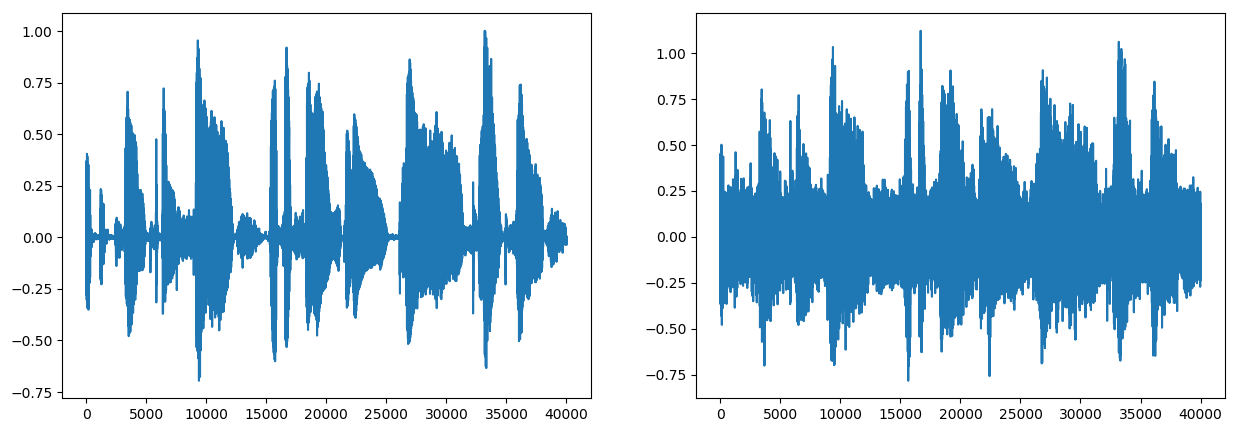

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000612937F0>

In [7]:
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(y_speech_true)
ax[2].plot(y_speech_n)

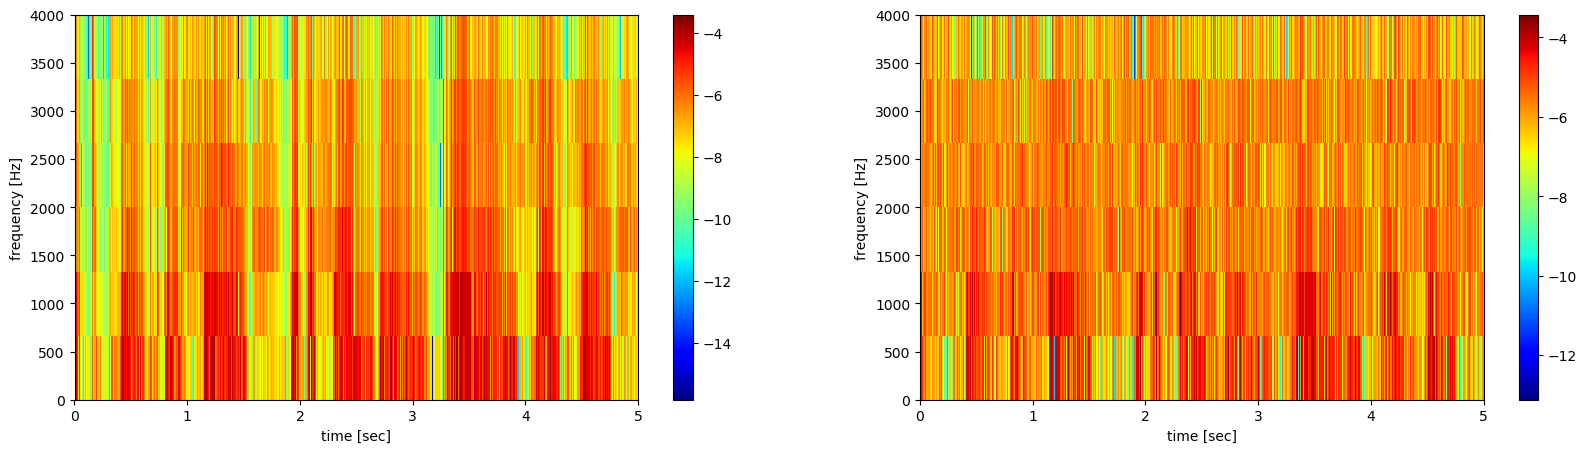

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(20,5))
plot_spectrogram(spectrogram(y_speech_true, bufsize, bufsize-stepsize_test, fs=fs), fs, ax=ax[1], colorbar=true)
#ax[1].get_images()[1].set_clim(-13, -3)
plot_spectrogram(spectrogram(y_speech_n, bufsize, bufsize-stepsize_test, fs=fs), fs, ax=ax[2], colorbar=true)
;

## just EM GMM

In [9]:
g = trainGMM(nr_clusters, z_speech[:,2:end-1], :diag)

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.031435e+04
      1       7.284853e+03      -3.029492e+03 |        3
      2       7.102484e+03      -1.823689e+02 |        3
      3       7.093069e+03      -9.415443e+00 |        2
      4       7.092531e+03      -5.378317e-01 |        0
      5       7.092531e+03       0.000000e+00 |        0
K-means converged with 5 iterations (objv = 7092.530919874329)


┌ Info: Initializing GMM, 3 Gaussians diag covariance 4 dimensions using 800 data points
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 800 data points using 5 iterations
│ 53.3 data points per parameter
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\3jRIL\src\train.jl:139


GMM{Float64} with 3 components in 4 dimensions and diag covariance
⋮


## Paper version

In [ ]:
μ, ν, ps, F = trainGSMM(nr_clusters, z_speech[:,2:end-1], fr_speech)

In [ ]:
plt.plot(F)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
cmp1 = ax[1].imshow(g.μ', origin="lower")
ax[1].set_title("inferred means after K+EM")
fig.colorbar(cmp1,ax=ax[1])
cmp2 = ax[2].imshow(μ, origin="lower")
ax[2].set_title("inferred means after VB")
fig.colorbar(cmp2,ax=ax[2])

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
cmp1 = ax[1].imshow(g.Σ', origin="lower")
ax[1].set_title("inferred means after K+EM")
fig.colorbar(cmp1,ax=ax[1])
cmp2 = ax[2].imshow(ν, origin="lower")
ax[2].set_title("inferred means after VB")
fig.colorbar(cmp2,ax=ax[2])

In [ ]:
g.w

In [ ]:
ps

## Train offline FL

In [ ]:
data, marginals, g = trainGSMM_FL_offline(nr_clusters, z_speech[:,2:end-1], y_speech, t, stepsize_train, bufsize, Σ_meas, fi; shuffle=true)
;

In [ ]:
data, marginals = perform_inference_offline(data, marginals, g.n; nr_its=10);

## Train online FL

In [ ]:
data, marginals, g = trainGSMM_FL_online(nr_clusters, z_speech[:,2:end-1], y_speech, t, stepsize_train, bufsize, Σ_meas, fi; shuffle=true)

In [ ]:
data, marginals = perform_inference_online(data, marginals, g.n; nr_its=10);